
Target:

    1. Get the code set up right by adding proper blocks and transitions.
    2. Reduce the number of parameters from 6.3M to less than 10,000

  Strategy

    1. Use as less number of channels and 3x3 to ring down the number of parameters
    2. Include global average pooling layer and use fully connected layer

Results:

    Best train accuracy: 98.33%
    Best test accuracy: 98.27%
    Parameters: 7880

Analysis:

    1. Good and light model. 
    2. Not overfitting(0.5% difference).
    3. Can push the model performance by tuning further 



# Import Libraries

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 

Here is the list of all the transformations which come pre-built with PyTorch

1.   Compose
2.   ToTensor
3.   ToPILImage
4. Normalize
5. Resize
6. Scale
7. CenterCrop
8. Pad
9. Lambda
10. RandomApply
11. RandomChoice
12. RandomOrder
13. RandomCrop
14. RandomHorizontalFlip
15. RandomVerticalFlip
16. RandomResizedCrop
17. RandomSizedCrop
18. FiveCrop
19. TenCrop
20. LinearTransformation
21. ColorJitter
22. RandomRotation
23. RandomAffine
24. Grayscale
25. RandomGrayscale
26. RandomPerspective
27. RandomErasing

You can read more about them [here](https://pytorch.org/docs/stable/_modules/torchvision/transforms/transforms.html)

In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0002)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


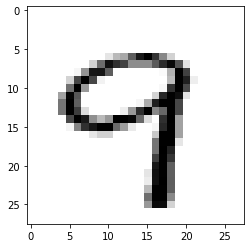

In [ ]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

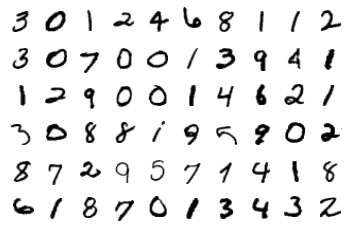

In [ ]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# How did we get those mean and std values which we used above?

Let's run a small experiment

In [ ]:
# simple transform
simple_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                      #  transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])
exp = datasets.MNIST('./data', train=True, download=True, transform=simple_transforms)
exp_data = exp.train_data
exp_data = exp.transform(exp_data.numpy())

print('[Train]')
print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', exp.train_data.size())
print(' - min:', torch.min(exp_data))
print(' - max:', torch.max(exp_data))
print(' - mean:', torch.mean(exp_data))
print(' - std:', torch.std(exp_data))
print(' - var:', torch.var(exp_data))

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1305)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


# The model
Let's start with the model we first saw

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(1, 6, 3, padding=1, bias = False),     # In -  28x28x1, Out -  28x28x6, RF - 3x3
                                   nn.ReLU(),
                                   nn.Conv2d(6, 12, 3, padding = 1, bias = False),  # In -  28x28x6, Out -  28x28x12, RF - 5x5
                                   nn.ReLU(),) 
        
        self.transition1 = nn.Sequential(nn.MaxPool2d(2,2),)                        # In -  28x28x12, Out -  14x14x12, RF - 6x6

        self.conv2 = nn.Sequential(nn.Conv2d(12, 16, 3, padding = 1, bias = False), # In -  14x14x12, Out -  14x14x16, RF - 10x10
                                   nn.ReLU(),
                                   nn.Conv2d(16, 16, 3, padding = 1, bias = False), # In -  14x14x16, Out -  14x14x16, RF - 14x14
                                   nn.ReLU(),)
        
        self.transition2 = nn.Sequential(nn.MaxPool2d(2,2),)                        # In -  14x14x16, Out -  7x7x16, RF - 16x16

        self.conv3 = nn.Sequential(nn.Conv2d(16, 16, 3, padding=1, bias = False),   # In -  7x7x16, Out -  7x7x16, RF - 24x24
                                     nn.ReLU(),)
        
        self.final_layers = nn.Sequential(nn.AvgPool2d(7, 7),
                                          nn.Conv2d(16, 32, 1, bias=False),         # In -  7x7x16, Out -  1x1x16, RF - 48x48
                                          nn.ReLU(),
                                          nn.Conv2d(32, 10, 1),
                                          nn.Flatten(),
                                          nn.LogSoftmax())


    def forward(self, x):
        x = self.conv1(x)
        x = self.transition1(x)
        x = self.conv2(x)
        x = self.transition2(x)
        x = self.conv3(x)
        x = self.final_layers(x)
        return x

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]              54
              ReLU-2            [-1, 6, 28, 28]               0
            Conv2d-3           [-1, 12, 28, 28]             648
              ReLU-4           [-1, 12, 28, 28]               0
         MaxPool2d-5           [-1, 12, 14, 14]               0
            Conv2d-6           [-1, 16, 14, 14]           1,728
              ReLU-7           [-1, 16, 14, 14]               0
            Conv2d-8           [-1, 16, 14, 14]           2,304
              ReLU-9           [-1, 16, 14, 14]               0
        MaxPool2d-10             [-1, 16, 7, 7]               0
           Conv2d-11             [-1, 16, 7, 7]           2,304
             ReLU-12             [-1, 16, 7, 7]               0
        AvgPool2d-13             [-1, 16, 1, 1]               0
           Conv2d-14             [

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


# Training and Testing

All right, so we have 6.3M params, and that's too many, we know that. But the purpose of this notebook is to set things right for our future experiments. 

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [ ]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
Loss=2.237652063369751 Batch_id=468 Accuracy=11.98: 100%|██████████| 469/469 [00:11<00:00, 39.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.2348, Accuracy: 1649/10000 (16.49%)

EPOCH: 1


Loss=0.7528422474861145 Batch_id=468 Accuracy=30.93: 100%|██████████| 469/469 [00:11<00:00, 39.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.8729, Accuracy: 6768/10000 (67.68%)

EPOCH: 2


Loss=0.16724540293216705 Batch_id=468 Accuracy=85.27: 100%|██████████| 469/469 [00:11<00:00, 39.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2780, Accuracy: 9109/10000 (91.09%)

EPOCH: 3


Loss=0.1544240564107895 Batch_id=468 Accuracy=92.58: 100%|██████████| 469/469 [00:11<00:00, 39.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1908, Accuracy: 9415/10000 (94.15%)

EPOCH: 4


Loss=0.19189201295375824 Batch_id=468 Accuracy=94.69: 100%|██████████| 469/469 [00:11<00:00, 39.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1180, Accuracy: 9646/10000 (96.46%)

EPOCH: 5


Loss=0.0933871790766716 Batch_id=468 Accuracy=95.92: 100%|██████████| 469/469 [00:11<00:00, 39.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0919, Accuracy: 9708/10000 (97.08%)

EPOCH: 6


Loss=0.2060679942369461 Batch_id=468 Accuracy=96.56: 100%|██████████| 469/469 [00:11<00:00, 39.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0889, Accuracy: 9729/10000 (97.29%)

EPOCH: 7


Loss=0.12375885248184204 Batch_id=468 Accuracy=96.98: 100%|██████████| 469/469 [00:11<00:00, 39.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1125, Accuracy: 9662/10000 (96.62%)

EPOCH: 8


Loss=0.1512327641248703 Batch_id=468 Accuracy=97.27: 100%|██████████| 469/469 [00:12<00:00, 38.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0734, Accuracy: 9776/10000 (97.76%)

EPOCH: 9


Loss=0.08622664213180542 Batch_id=468 Accuracy=97.47: 100%|██████████| 469/469 [00:12<00:00, 37.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0701, Accuracy: 9782/10000 (97.82%)

EPOCH: 10


Loss=0.03907116875052452 Batch_id=468 Accuracy=97.74: 100%|██████████| 469/469 [00:12<00:00, 38.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0606, Accuracy: 9808/10000 (98.08%)

EPOCH: 11


Loss=0.12447750568389893 Batch_id=468 Accuracy=97.90: 100%|██████████| 469/469 [00:11<00:00, 39.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0644, Accuracy: 9804/10000 (98.04%)

EPOCH: 12


Loss=0.03776441887021065 Batch_id=468 Accuracy=98.01: 100%|██████████| 469/469 [00:12<00:00, 38.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0472, Accuracy: 9863/10000 (98.63%)

EPOCH: 13


Loss=0.15053124725818634 Batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:12<00:00, 39.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0610, Accuracy: 9812/10000 (98.12%)

EPOCH: 14


Loss=0.03981577232480049 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:11<00:00, 39.22it/s]



Test set: Average loss: 0.0522, Accuracy: 9827/10000 (98.27%)



Text(0.5, 1.0, 'Test Accuracy')

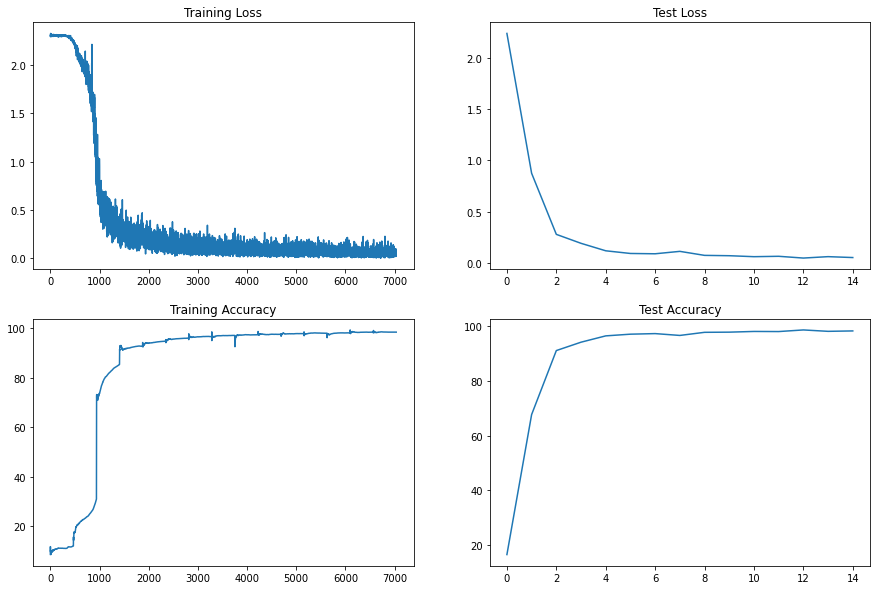

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")